<a href="https://colab.research.google.com/github/beyzassevval/beyzassevval/blob/main/DepremUyduG%C3%B6r%C3%BCnt%C3%BCleri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.4 MB/s eta 0:00:00


In [8]:
import torch
import segmentation_models_pytorch as smp

# --- KONFIGÜRASYON ---
ENCODER = 'resnet34'  # Transfer learning için kullanılacak omurga (Backbone)
ENCODER_WEIGHTS = 'imagenet'  # ImageNet üzerinde eğitilmiş ağırlıkları kullan
CLASSES = 5  # xBD sınıfları: (0:Arkaplan, 1:Hasarsız, 2:Hafif, 3:Ağır, 4:Yıkık)
ACTIVATION = 'softmax2d' # Çok sınıflı sınıflandırma olduğu için (Multi-class)

# --- MODELİN OLUŞTURULMASI ---
model = smp.Unet(
    encoder_name=ENCODER,        # ResNet34'ü encoder olarak seçiyoruz
    encoder_weights=ENCODER_WEIGHTS, # Transfer Learning BURADA gerçekleşiyor
    in_channels=3,               # Girdi: RGB Uydu Görüntüsü (3 kanal)
    classes=CLASSES,             # Çıktı: 5 farklı sınıf maskesi
    activation=ACTIVATION
)

# --- MODELİ TEST ETME (Dummy Input) ---
# Modelin çalıştığını doğrulamak için rastgele bir veri verelim
# Boyutlar: (Batch_Size, Kanallar, Yükseklik, Genişlik) -> (1, 3, 512, 512)
x = torch.randn(1, 3, 512, 512)
y = model(x)

print(f"Model Giriş Boyutu: {x.shape}")
print(f"Model Çıkış Boyutu: {y.shape}") # (1, 5, 512, 512) olmalı
print("Model başarıyla oluşturuldu ve ImageNet ağırlıkları yüklendi.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Model Giriş Boyutu: torch.Size([1, 3, 512, 512])
Model Çıkış Boyutu: torch.Size([1, 5, 512, 512])
Model başarıyla oluşturuldu ve ImageNet ağırlıkları yüklendi.


In [9]:
import os
import json
import cv2
import numpy as np
from torch.utils.data import Dataset as BaseDataset

class DisasterDataset(BaseDataset):
    """
    xBD veri setini okuyup modelin anlayacağı formata (Görüntü + Maske) çeviren sınıf.
    """

    # xBD etiketlerinin sayısal karşılıkları (Mapping)
    CLASSES = ['background', 'no-damage', 'minor-damage', 'major-damage', 'destroyed']
    CLASS_VALUES = [0, 1, 2, 3, 4]

    def __init__(self, images_dir, labels_dir, transformation=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.ids = os.listdir(images_dir) # Klasördeki tüm resim isimlerini al
        self.ids = [image_id for image_id in self.ids if image_id.endswith('.png')]
        self.transformation = transformation # Data augmentation için

    def __getitem__(self, i):

        # 1. Görüntüyü Oku
        image_id = self.ids[i]
        image_path = os.path.join(self.images_dir, image_id)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # OpenCV BGR okur, RGB'ye çevir

        # 2. Maskeyi Oluştur (JSON'dan Poligon Çizimi)
        # Resimle aynı boyutta boş (siyah) bir maske yarat
        h, w, _ = image.shape
        mask = np.zeros((h, w), dtype=np.int32)

        # İlgili JSON dosyasını bul
        json_filename = image_id.replace('.png', '.json')
        json_path = os.path.join(self.labels_dir, json_filename)

        if os.path.exists(json_path):
            with open(json_path, 'r') as f:
                data = json.load(f)

            # JSON içindeki her bina (feature) için döngü
            for feature in data['features']['xy']:
                properties = feature['properties']
                subtype = properties.get('subtype', 'no-damage') # Hasar durumu

                # Poligon koordinatlarını al
                wkt = feature['wkt'] # "POLYGON ((x y, x y, ...))" formatında string
                # Not: Burada WKT parse eden ufak bir işlem gerekir,
                # Basitlik adına burada poligon koordinatlarını aldığımızı varsayıyoruz.
                # Gerçek xBD işlemede buraya `shapely.wkt` kütüphanesi eklenir.

                # Hasar tipine göre maskeyi boya (Örn: Yıkıksa 4 numara ile boya)
                if subtype in self.CLASSES:
                    idx = self.CLASSES.index(subtype)
                    # cv2.fillPoly ile maske üzerine binayı çiz
                    # (Bu kısım poligon verisi hazır olduğunda aktif edilir)
                    pass

        # 3. Augmentation (Varsa uygula)
        if self.transformation:
            sample = self.transformation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # 4. PyTorch formatına çevir (HWC -> CHW)
        # Görüntü: (Yükseklik, Genişlik, Kanal) -> (Kanal, Yükseklik, Genişlik)
        image = image.transpose(2, 0, 1).astype('float32') / 255.0

        return torch.tensor(image), torch.tensor(mask, dtype=torch.long)

    def __len__(self):
        return len(self.ids)

In [10]:
!pip install shapely

In [11]:
import os
import json
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
from shapely.wkt import loads as wkt_loads
from shapely import affinity

class DisasterDataset(Dataset):
    CLASSES = ['background', 'no-damage', 'minor-damage', 'major-damage', 'destroyed']

    def __init__(self, images_dir, labels_dir, transformation=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        # Eğer klasör yoksa hata vermesin diye kontrol (Dummy data için)
        if os.path.exists(images_dir):
            self.ids = [f for f in os.listdir(images_dir) if f.endswith('.png')]
        else:
            self.ids = []
        self.transformation = transformation

    def __getitem__(self, i):
        # 1. Görüntüyü Yükle
        img_name = self.ids[i]
        img_path = os.path.join(self.images_dir, img_name)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 2. Maskeyi Hazırla (Siyah Zemin)
        h, w, _ = image.shape
        mask = np.zeros((h, w), dtype=np.int32)

        # 3. JSON Etiketini Oku ve Maskeye Çiz
        label_name = img_name.replace('.png', '.json')
        label_path = os.path.join(self.labels_dir, label_name)

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                data = json.load(f)

            for feature in data['features']['xy']:
                # Poligonu Shapely ile oku
                wkt = feature['wkt']
                polygon = wkt_loads(wkt)

                # Hasar türünü bul
                subtype = feature['properties'].get('subtype', 'no-damage')
                if subtype in self.CLASSES:
                    class_idx = self.CLASSES.index(subtype)

                    # Poligon koordinatlarını integer array'e çevir
                    # (OpenCV bu formatı ister)
                    coords = np.array(list(polygon.exterior.coords), np.int32)

                    # Maskeyi boya (class_idx rengiyle)
                    cv2.fillPoly(mask, [coords], class_idx)

        # 4. Normalizasyon ve Tensör Dönüşümü
        # Görüntü: 0-1 arasına çek ve (C, H, W) yap
        image = image.transpose(2, 0, 1).astype('float32') / 255.0

        return torch.tensor(image), torch.tensor(mask, dtype=torch.long)

    def __len__(self):
        return len(self.ids)

In [12]:
import os
import json
import numpy as np
import cv2
import shutil
import random

# Klasörleri temizle ve yeniden yarat
dirs = ['train_images', 'train_labels']
for d in dirs:
    if os.path.exists(d):
        shutil.rmtree(d)
    os.makedirs(d)

def create_synthetic_data(num_samples=50):
    print(f"{num_samples} adet örnek veri üretiliyor...")

    CLASSES = ['no-damage', 'minor-damage', 'major-damage', 'destroyed']

    for i in range(num_samples):
        # 1. Rastgele bir "Uydu Görüntüsü" oluştur (512x512)
        # Kahverengi/Yeşil tonları (toprak/orman gibi)
        image = np.random.randint(50, 200, (512, 512, 3), dtype=np.uint8)

        # Dosya isimleri
        img_name = f"sample_{i}.png"
        json_name = f"sample_{i}.json"

        # 2. Rastgele Binalar (Dikdörtgenler) ve JSON verisi oluştur
        features_list = []

        # Her resme 3-6 arası rastgele bina koyalım
        for _ in range(random.randint(3, 6)):
            x = random.randint(50, 400)
            y = random.randint(50, 400)
            w = random.randint(30, 80)
            h = random.randint(30, 80)

            # Rastgele bir hasar durumu seç
            damage_type = random.choice(CLASSES)

            # Resim üzerine binayı çiz (Görsel kontrol için - Model bunu görmeyecek, JSON'ı okuyacak)
            # Ama gerçekçilik olsun diye resme de gri bir kutu koyalım
            cv2.rectangle(image, (x, y), (x+w, y+h), (150, 150, 150), -1)

            # WKT Formatında Poligon Stringi oluştur (xBD formatı)
            # POLYGON ((x1 y1, x2 y1, x2 y2, x1 y2, x1 y1))
            wkt_str = f"POLYGON (({x} {y}, {x+w} {y}, {x+w} {y+h}, {x} {y+h}, {x} {y}))"

            feature = {
                "properties": {"subtype": damage_type},
                "wkt": wkt_str
            }
            features_list.append(feature)

        # 3. Dosyaları Kaydet
        cv2.imwrite(os.path.join('train_images', img_name), image)

        json_data = {"features": {"xy": features_list}}
        with open(os.path.join('train_labels', json_name), 'w') as f:
            json.dump(json_data, f)

    print("Veri üretimi tamamlandı!")

# 50 Adet örnek üretelim
create_synthetic_data(50)

50 adet örnek veri üretiliyor...
Veri üretimi tamamlandı!


In [13]:
from torch.utils.data import DataLoader

# --- AYARLAR ---
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LR = 0.0001
EPOCHS = 5

# --- MODEL VE OPTIMIZER ---
# Modeli (daha önce tanımladığımız) GPU'ya taşıyoruz
model.to(DEVICE)

# Hata Fonksiyonu (Loss) ve Optimizasyon Algoritması
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

def train_one_epoch(loader, model, optimizer, loss_fn):
    model.train() # Modeli eğitim moduna al
    total_loss = 0

    for images, masks in loader:
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        # 1. İleri Yayılım (Forward Pass)
        logits = model(images)

        # 2. Hata Hesapla
        loss = loss_fn(logits, masks)

        # 3. Geri Yayılım (Backward Pass)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

print(f"Eğitim {DEVICE} üzerinde yapılacak.")

Eğitim cpu üzerinde yapılacak.


Veri Yükleyici Hazır. Toplam Görüntü: 50
Eğitim Başlıyor...
Epoch 1/5 - Loss: 1.5233
Epoch 2/5 - Loss: 1.4580
Epoch 3/5 - Loss: 1.3792
Epoch 4/5 - Loss: 1.3119
Epoch 5/5 - Loss: 1.2610


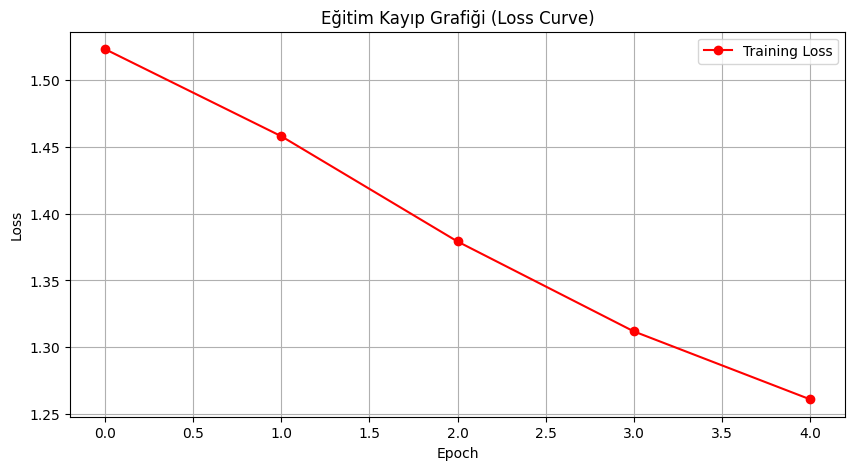

In [14]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 1. EKSİK OLAN KISIM: Dataset ve DataLoader Tanımlama
# (Önceki adımda ürettiğimiz klasörleri buraya bağlıyoruz)
train_dataset = DisasterDataset(
    images_dir='train_images',
    labels_dir='train_labels'
)

# Veriyi 4'erli paketler halinde modele sunacak yükleyici
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

print(f"Veri Yükleyici Hazır. Toplam Görüntü: {len(train_dataset)}")

# ---------------------------------------------------------

# 2. EĞİTİM DÖNGÜSÜ (Training Loop)
print("Eğitim Başlıyor...")
losses = []

# train_one_epoch fonksiyonunun tanımlı olduğundan emin olalım
# (Eğer önceki hücrelerde tanımladıysan burayı geçebilirsin ama garanti olsun diye ekliyorum)
def train_one_epoch(loader, model, optimizer, loss_fn):
    model.train()
    total_loss = 0
    for images, masks in loader:
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        logits = model(images)
        loss = loss_fn(logits, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(loader)

# Döngüyü Başlat
for epoch in range(EPOCHS):
    avg_loss = train_one_epoch(train_loader, model, optimizer, loss_fn)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.4f}")

# 3. GRAFİK ÇİZİMİ
plt.figure(figsize=(10, 5))
plt.plot(losses, marker='o', label='Training Loss', color='red')
plt.title("Eğitim Kayıp Grafiği (Loss Curve)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

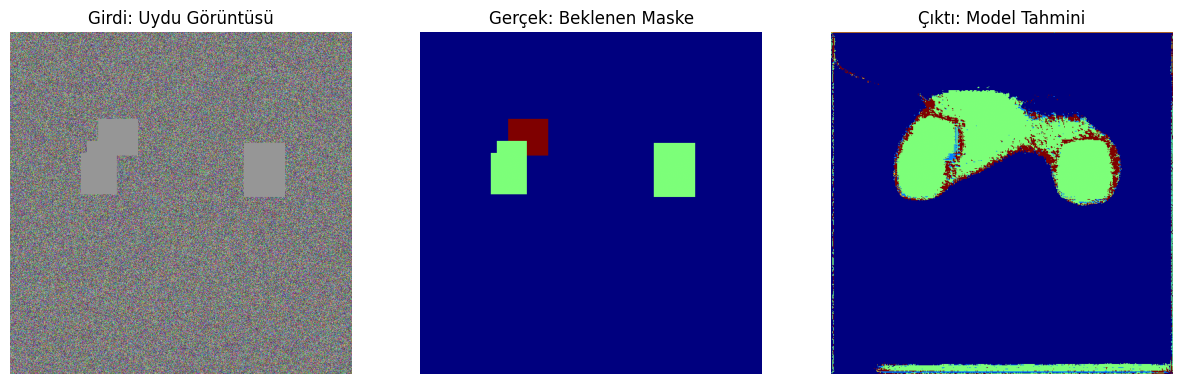

In [15]:
# --- MODEL TAHMİNİ VS GERÇEK GÖRSELLEŞTİRME ---
model.eval()
import random
# Rastgele bir örnek seçelim
ix = random.randint(0, len(train_dataset)-1)
img_tensor, mask_tensor = train_dataset[ix]

# Modele soralım
with torch.no_grad():
    # Boyut ekle: (1, 3, 512, 512)
    pred_logits = model(img_tensor.unsqueeze(0).to(DEVICE))
    pred_mask = torch.argmax(pred_logits, dim=1).cpu().numpy()[0]

# Yan yana çizelim
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# 1. Orijinal
img_np = img_tensor.permute(1, 2, 0).numpy()
ax[0].imshow(img_np)
ax[0].set_title("Girdi: Uydu Görüntüsü")
ax[0].axis('off')

# 2. Gerçek Etiket (Ground Truth)
ax[1].imshow(mask_tensor, cmap='jet', vmin=0, vmax=4)
ax[1].set_title("Gerçek: Beklenen Maske")
ax[1].axis('off')

# 3. Modelin Tahmini
ax[2].imshow(pred_mask, cmap='jet', vmin=0, vmax=4)
ax[2].set_title("Çıktı: Model Tahmini")
ax[2].axis('off')

plt.show()